# IXS/ETH Vault Performance Analysis

The UniV4 pool liquidity is primarily managed by an Arrakis vault (`0x90bde935ce7feb6636afd5a1a0340af45eeae600`).

### Questions

1. How have vault token amounts (IXS and ETH) and vault composition (USD value split) evolved over time?
2. How does vault performance compare to holding the initial amounts (HODL) over time since inception?
3. What is the theoretical full-range LP performance over the same period?
4. What is the performance differential, and what are the tradeoffs of active concentrated management vs passive LP?

In [1]:
import os
import sys
import math
from web3 import Web3
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("..")

from src.config import (
    STATE_VIEW, IXS, ETH,
    IXS_POOL_ID_BYTES, ARRAKIS_VAULT, CHAINLINK_ETH_USD,
)
from src.abis import STATEVIEW_ABI_EXTENDED, ARRAKIS_VAULT_ABI, CHAINLINK_ABI
from src.block_utils import (
    generate_daily_block_samples, blocks_to_timestamps,
    timestamps_to_dates, get_latest_block,
)
from src.price_feeds import get_eth_usd_at_block, get_ixs_eth_price_from_v4
from src.vault_performance import (
    batch_vault_underlying,
    calculate_hodl_value, calculate_fullrange_lp_value,
    compute_annualized_return, decompose_vault_returns,
)
from src.migration_detection import find_v4_pool_creation_block
from src.cache import load_cache, save_cache

load_dotenv()
os.makedirs('plots', exist_ok=True)
os.makedirs('data', exist_ok=True)
w3 = Web3(Web3.HTTPProvider(os.getenv('rpc_url_mainnet')))
print(f'Connected: {w3.is_connected()}')
print(f'Latest block: {w3.eth.block_number}')

Connected: True
Latest block: 24507036


In [2]:
stateview = w3.eth.contract(address=Web3.to_checksum_address(STATE_VIEW), abi=STATEVIEW_ABI_EXTENDED)  # V4 pool state: slot0, liquidity, ticks
vault = w3.eth.contract(address=Web3.to_checksum_address(ARRAKIS_VAULT), abi=ARRAKIS_VAULT_ABI)  # Arrakis vault: token balances, total supply
chainlink = w3.eth.contract(address=Web3.to_checksum_address(CHAINLINK_ETH_USD), abi=CHAINLINK_ABI)  # Chainlink oracle: on-chain ETH/USD price feed

# Vault token0 = IXS, token1 = native ETH
vt0 = vault.functions.token0().call()
vt1 = vault.functions.token1().call()
ixs_is_token0_vault = vt0.lower() == IXS.lower()
print(f"Vault token0: {vt0} ({'IXS' if ixs_is_token0_vault else 'ETH'})")
print(f"Vault token1: {vt1} ({'ETH' if ixs_is_token0_vault else 'IXS'})")

Vault token0: 0x73d7c860998CA3c01Ce8c808F5577d94d545d1b4 (IXS)
Vault token1: 0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE (ETH)


## Theory Part 1: HODL Benchmark

The simplest benchmark -- hold the initial token amounts without providing liquidity:

$$V_{\text{HODL}}(t) = n_0 \cdot P_0(t) + n_1 \cdot P_1(t)$$

where $n_0, n_1$ are initial token amounts and $P_0(t), P_1(t)$ are current USD prices. Any LP strategy can be measured against this baseline: the difference is the **opportunity cost** of providing liquidity instead of holding.

## Theory Part 2: Full-Range LP Benchmark

The second benchmark -- a passive full-range LP (V2-style, $x \cdot y = k$). As prices diverge, the AMM mechanically rebalances inventory. Define the price ratio change:

$$r = \frac{p_t}{p_0}$$

The new reserves follow from solving the two constraints simultaneously -- the invariant must hold and the reserve ratio must reflect the new price:

$$x_t \cdot y_t = k \quad \text{and} \quad \frac{y_t}{x_t} = p_t$$

This gives $x_t = x_0 / \sqrt{r}$, $y_t = y_0 \cdot \sqrt{r}$, and the LP value relative to HODL is the **IL factor**:

$$\frac{V_{\text{fullrange}}}{V_{\text{HODL}}} = \frac{2\sqrt{r}}{1 + r} \leq 1$$

**Impermanent loss** is defined as:

$$\text{IL} = V_{\text{fullrange}} - V_{\text{HODL}} = V_{\text{HODL}} \left(\frac{2\sqrt{r}}{1 + r} - 1\right) \leq 0$$

**Important:** Our $V_{\text{fullrange}}$ uses this *pure mechanical* formula -- it does **not** include fee income. This isolates IL cleanly. In practice a real V2 LP would also earn trading fees, which partially offset IL.

Comparing the vault against this benchmark tells us a different story than vs HODL: it measures the **opportunity cost of active management vs passive LPing**.

## Theory Part 3: Concentrated Liquidity

### Fee Share

In V2, every LP covers the full price range. Fee share is simply proportional to capital:
$$\text{fee\_share}_{\text{V2}} = \frac{L_i}{L_{\text{total}}}$$
This works well if you own a large share of the pool's liquidity, you passively collect a large share of fees.

In V3/V4, only liquidity covering the **active tick** earns fees on a given swap:
$$\text{fee\_share}_{\text{V3/V4}} = \frac{L_i}{L_{\text{active}}}$$
where $L_{\text{active}} = \sum L_j$ over positions $j$ that include the current tick.

### Concentration Amplification

A position concentrated in $[p_a, p_b]$ provides more liquidity per unit of capital than a full-range position. To derive the amplification factor, consider the $y$-token real reserves for a position with liquidity $L$:

$$y_{\text{real}} = L\left(\sqrt{p} - \sqrt{p_a}\right) \quad \text{(concentrated)}, \qquad y_{\text{real}} = L\left(\sqrt{p} - 0\right) \quad \text{(full-range, } p_a = 0\text{)}$$

For the same capital deployed (same $y_{\text{real}}$), the concentrated position achieves a higher $L$:

$$L_{\text{conc}} \cdot \left(\sqrt{p} - \sqrt{p_a}\right) = L_{\text{full}} \cdot \sqrt{p}$$

At the upper bound $p = p_b$:

$$\frac{L_{\text{concentrated}}}{L_{\text{fullrange}}} = \frac{\sqrt{p_b}}{\sqrt{p_b} - \sqrt{p_a}}$$

In other words: earn the same fees with far less capital, or earn more fees with the same capital.

### The Tradeoff

- **Higher fee capture per dollar of TVL** -- all capital participates in every trade within range.
- **Amplified IL per price move** -- the position behaves like a leveraged full-range LP. The narrower the range, the more aggressively the AMM rebalances inventory.

This is the fundamental tradeoff Arrakis manages -- tighter ranges earn more fees but suffer more IL when price moves.

## Theory Part 4: Return Decomposition

We decompose vault returns into three additive components:

$$V_{\text{vault}} = V_{\text{HODL}} + \underbrace{(V_{\text{fullrange}} - V_{\text{HODL}})}_{\text{IL (pure, fee-free)}} + \underbrace{(V_{\text{vault}} - V_{\text{fullrange}})}_{\text{management premium}}$$

Each term has a clear interpretation:

- **Price return** = $V_{\text{HODL}}(t) - V_{\text{HODL}}(0)$;  pure token price movement, no LP activity.
- **IL (pure, fee-free)** = $V_{\text{fullrange}} - V_{\text{HODL}}$; the mechanical cost of providing full-range liquidity. Always $\leq 0$ because $V_{\text{fullrange}}$ excludes fees by construction (it is simply $V_{\text{HODL}} \cdot \frac{2\sqrt{r}}{1+r}$).
- **Management premium** = $V_{\text{vault}} - V_{\text{fullrange}}$; everything Arrakis adds on top of a passive fee-free full-range LP: fee income from concentrated positions, rebalancing alpha, and any residual IL difference from concentration. This term can be positive or negative.

---

## Setup: Vault Start & Daily Sampling

In [3]:
latest_block = get_latest_block(w3)
latest_block = (latest_block // 7200) * 7200  # pin to day boundary for stable cache keys
search_start = latest_block - 7200 * 365

# Use V4 pool creation as start (need pool prices to exist)
print("Finding V4 pool creation block...")
v4_start = find_v4_pool_creation_block(
    stateview, IXS_POOL_ID_BYTES, search_start, latest_block
)
print(f"V4 pool created: block {v4_start:,}")

# Skip first week: liquidity was still settling post-migration (same as D1 notebook)
VAULT_START = v4_start + 7200 * 7
sample_blocks = generate_daily_block_samples(VAULT_START, latest_block)
print(f"Daily samples: {len(sample_blocks)} (starting 1 week after pool creation)")

# Cache timestamps
_ts_params = {"blocks": sample_blocks}
_cached_ts = load_cache("vault_timestamps", _ts_params)
if _cached_ts is None:
    print("Fetching timestamps...")
    sample_ts = blocks_to_timestamps(w3, sample_blocks)
    save_cache("vault_timestamps", sample_ts, _ts_params)
else:
    sample_ts = _cached_ts

sample_dates = timestamps_to_dates(sample_ts)
dates = pd.to_datetime(sample_dates)
print(f"Date range: {sample_dates[0]} to {sample_dates[-1]}")

Finding V4 pool creation block...
V4 pool created: block 23,982,496
Daily samples: 67 (starting 1 week after pool creation)
  Cache hit: vault_timestamps_de8b2b3a.json
Date range: 2025-12-17 to 2026-02-21


---

## Q1. Vault Token Amounts and Composition Over Time

In [4]:
# --- Fetch all data needed for Q1 ---

# Vault underlying (IXS + ETH amounts at each block)
_params = {"blocks": sample_blocks}
_cached = load_cache("vault_underlying", _params)
if _cached is None:
    print("Fetching vault underlying at each block...")
    vault_data = batch_vault_underlying(vault, sample_blocks)
    save_cache("vault_underlying", [list(d) for d in vault_data], _params)
else:
    vault_data = [tuple(d) for d in _cached]

if ixs_is_token0_vault:
    ixs_amounts = [d[1] / 1e18 for d in vault_data]
    eth_amounts = [d[2] / 1e18 for d in vault_data]
else:
    ixs_amounts = [d[2] / 1e18 for d in vault_data]
    eth_amounts = [d[1] / 1e18 for d in vault_data]

# IXS/ETH from V4 pool (for ETH-denominated valuation)
_cached_ixs = load_cache("vault_ixs_eth", _params)
if _cached_ixs is None:
    print("Fetching IXS/ETH from V4 pool...")
    ixs_eth_prices = []
    for block in sample_blocks:
        try:
            price = get_ixs_eth_price_from_v4(
                stateview, IXS_POOL_ID_BYTES, block, ixs_is_currency0=False
            )
            ixs_eth_prices.append(price)
        except Exception:
            ixs_eth_prices.append(0.0)
    save_cache("vault_ixs_eth", ixs_eth_prices, _params)
else:
    ixs_eth_prices = _cached_ixs

# ETH-denominated vault value
ixs_in_eth = [amt * price for amt, price in zip(ixs_amounts, ixs_eth_prices)]
total_eth = [ie + e for ie, e in zip(ixs_in_eth, eth_amounts)]

# Range data + rebalance detection (needed for overlay on Q1 charts)
from src.config import ARRAKIS_MODULE
from src.abis import ARRAKIS_MODULE_ABI
from src.vault_rebalancing import (
    batch_pool_state_and_ranges, detect_rebalances,
    ranges_to_prices, compute_capital_efficiency,
    estimate_rebalancing_gas_cost,
)

module = w3.eth.contract(
    address=Web3.to_checksum_address(ARRAKIS_MODULE), abi=ARRAKIS_MODULE_ABI
)

_cached_rd = load_cache("vault_range_data", _params)
if _cached_rd is None:
    print("Fetching pool state + vault ranges at each sample block...")
    range_data = batch_pool_state_and_ranges(
        stateview, module, IXS_POOL_ID_BYTES, sample_blocks
    )
    save_cache("vault_range_data", range_data, _params)
else:
    range_data = _cached_rd

rebalance_idx = detect_rebalances(range_data)
rebalance_dates = [dates[i] for i in rebalance_idx]

print(f"Initial: {ixs_amounts[0]:,.0f} IXS + {eth_amounts[0]:.2f} ETH = {total_eth[0]:.2f} ETH total")
print(f"Current: {ixs_amounts[-1]:,.0f} IXS + {eth_amounts[-1]:.2f} ETH = {total_eth[-1]:.2f} ETH total")
print(f"Rebalances detected: {len(rebalance_idx)}")

  Cache hit: vault_underlying_de8b2b3a.json
  Cache hit: vault_ixs_eth_de8b2b3a.json
Fetching pool state + vault ranges at each sample block...
  Cached: vault_range_data_de8b2b3a.json
Initial: 3,767,710 IXS + 117.41 ETH = 293.78 ETH total
Current: 4,266,146 IXS + 95.62 ETH = 216.56 ETH total
Rebalances detected: 13


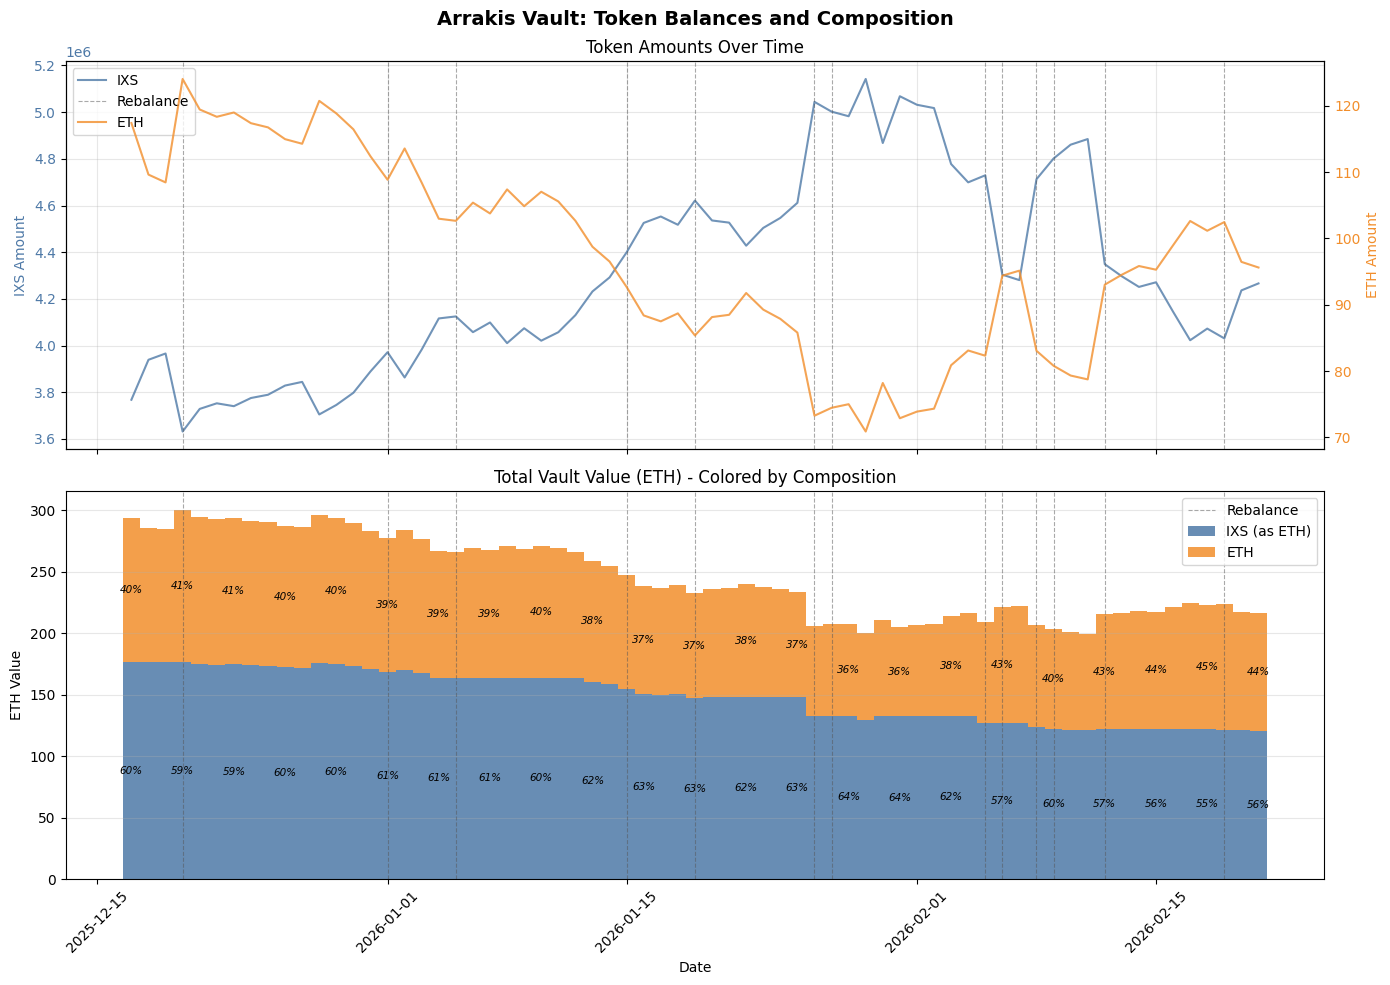

IXS share: 60.0% -> 55.8%
ETH share: 40.0% -> 44.2%
Total ETH: 293.78 -> 216.56


In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Arrakis Vault: Token Balances and Composition', fontsize=14, fontweight='bold')

def _add_rebalance_lines(ax, rebalance_dates, label=True):
    """Overlay rebalance event vertical lines."""
    for i, rd in enumerate(rebalance_dates):
        kw = {"label": "Rebalance"} if (i == 0 and label) else {}
        ax.axvline(rd, color='#555555', linestyle='--', alpha=0.5, linewidth=0.8, **kw)

# Panel 1: Token amounts (dual y-axis)
color_ixs, color_eth = '#4e79a7', '#f28e2b'
ax1.set_ylabel('IXS Amount', color=color_ixs)
ax1.plot(dates, ixs_amounts, color=color_ixs, alpha=0.8, linewidth=1.5, label='IXS')
ax1.tick_params(axis='y', labelcolor=color_ixs)

ax1r = ax1.twinx()
ax1r.set_ylabel('ETH Amount', color=color_eth)
ax1r.plot(dates, eth_amounts, color=color_eth, alpha=0.8, linewidth=1.5, label='ETH')
ax1r.tick_params(axis='y', labelcolor=color_eth)

_add_rebalance_lines(ax1, rebalance_dates)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1r.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.set_title('Token Amounts Over Time')
ax1.grid(True, alpha=0.3)

# Panel 2: Stacked bar -- total height = ETH value, split by IXS(blue) + ETH(orange)
if len(dates) > 1:
    bar_width = (dates[1] - dates[0]) * 1.0
else:
    bar_width = pd.Timedelta(days=1)

ax2.bar(dates, ixs_in_eth, width=bar_width, color=color_ixs, alpha=0.85,
        label='IXS (as ETH)', linewidth=0)
ax2.bar(dates, eth_amounts, width=bar_width, bottom=ixs_in_eth, color=color_eth,
        alpha=0.85, label='ETH', linewidth=0)

# Add percentage labels on every ~10th bar (+ first and last)
ixs_pct = [ie / te * 100 if te > 0 else 0 for ie, te in zip(ixs_in_eth, total_eth)]
eth_pct = [e / te * 100 if te > 0 else 0 for e, te in zip(eth_amounts, total_eth)]

n = len(dates)
step = max(1, n // 20)  # ~7 labels across the chart
label_indices = list(range(0, n, step))
if (n - 1) not in label_indices:
    label_indices.append(n - 1)

for i in label_indices:
    # IXS % in the blue portion
    ax2.text(dates[i], ixs_in_eth[i] / 2, f'{ixs_pct[i]:.0f}%',
             ha='center', va='center', fontsize=7.5, fontstyle='italic', color='black')
    # ETH % in the orange portion
    ax2.text(dates[i], ixs_in_eth[i] + eth_amounts[i] / 2, f'{eth_pct[i]:.0f}%',
             ha='center', va='center', fontsize=7.5, fontstyle='italic', color='black')

_add_rebalance_lines(ax2, rebalance_dates)
ax2.set_xlabel('Date')
ax2.set_ylabel('ETH Value')
ax2.set_title('Total Vault Value (ETH) - Colored by Composition')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('plots/ixs_vault_token_amounts.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"IXS share: {ixs_pct[0]:.1f}% -> {ixs_pct[-1]:.1f}%")
print(f"ETH share: {eth_pct[0]:.1f}% -> {eth_pct[-1]:.1f}%")
print(f"Total ETH: {total_eth[0]:.2f} -> {total_eth[-1]:.2f}")

### USD Price Data

ETH/USD from Chainlink oracle -- needed for USD-denominated benchmarking (HODL, full-range LP) in Q2-Q4.

In [12]:
from src.price_feeds import batch_eth_usd_prices

_params = {"blocks": sample_blocks}
_cached_eth = load_cache("vault_eth_usd", _params)
if _cached_eth is None:
    print("Fetching ETH/USD from Chainlink...")
    eth_usd_prices = batch_eth_usd_prices(chainlink, sample_blocks)
    save_cache("vault_eth_usd", eth_usd_prices, _params)
else:
    eth_usd_prices = _cached_eth

# Derived USD prices for Q2-Q4 benchmarking
ixs_usd_prices = [ie * eu for ie, eu in zip(ixs_eth_prices, eth_usd_prices)]
ixs_usd_values = [amt * price for amt, price in zip(ixs_amounts, ixs_usd_prices)]
eth_usd_values = [amt * price for amt, price in zip(eth_amounts, eth_usd_prices)]
total_usd = [i + e for i, e in zip(ixs_usd_values, eth_usd_values)]

print(f"ETH/USD range: ${min(eth_usd_prices):,.2f} - ${max(eth_usd_prices):,.2f}")
print(f"Vault USD value: ${total_usd[0]:,.2f} (initial) -> ${total_usd[-1]:,.2f} (current)")

  Cache hit: vault_eth_usd_de8b2b3a.json
ETH/USD range: $1,916.41 - $3,346.82
Vault USD value: $863,554.89 (initial) -> $426,125.93 (current)


---

## Q2. Vault Performance vs HODL Benchmark

HODL benchmark: hold the initial token amounts without providing liquidity.

$$V_{\text{HODL}}(t) = n_0 \cdot P_0(t) + n_1 \cdot P_1(t)$$

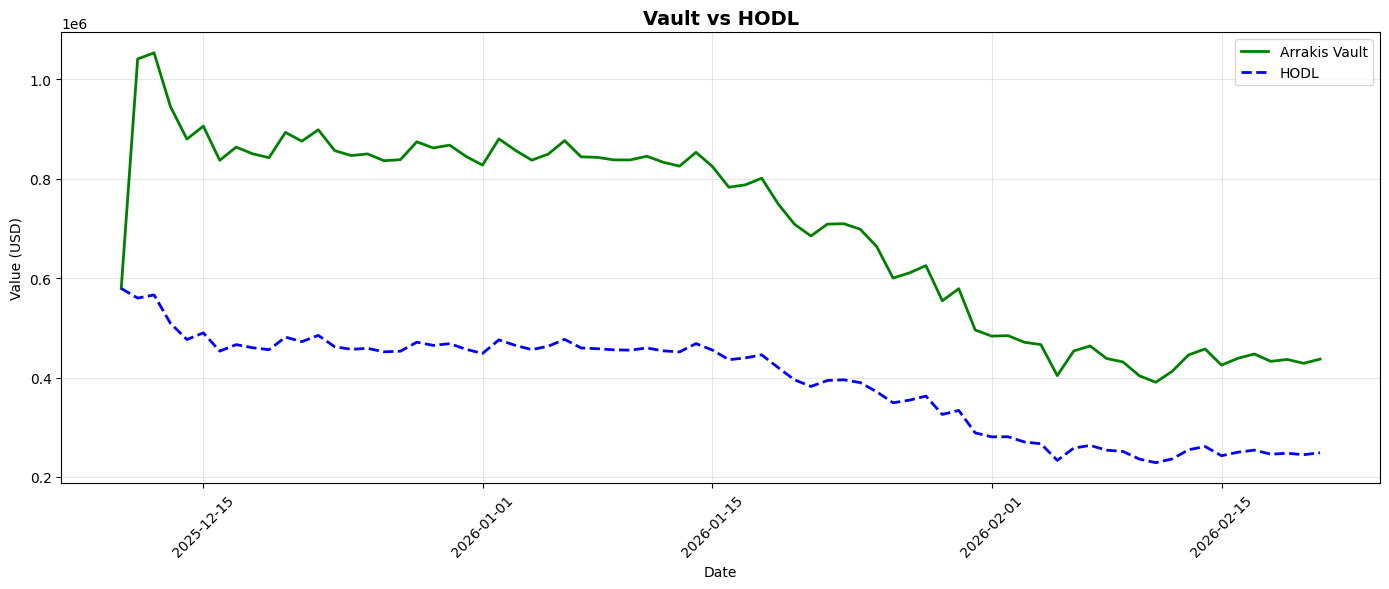

Vault: $437,081.28
HODL:  $248,809.70
Diff:  +75.67%


In [8]:
init_ixs = ixs_amounts[0]
init_eth = eth_amounts[0]

hodl_values = [
    calculate_hodl_value(init_ixs, init_eth, iu, eu)
    for iu, eu in zip(ixs_usd_prices, eth_usd_prices)
]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates, total_usd, 'g-', linewidth=2, label='Arrakis Vault')
ax.plot(dates, hodl_values, 'b--', linewidth=2, label='HODL')

ax.set_xlabel('Date')
ax.set_ylabel('Value (USD)')
ax.set_title('Vault vs HODL', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('plots/ixs_vault_vs_hodl.png', dpi=150, bbox_inches='tight')
plt.show()

if hodl_values[-1] > 0:
    print(f"Vault: ${total_usd[-1]:,.2f}")
    print(f"HODL:  ${hodl_values[-1]:,.2f}")
    print(f"Diff:  {(total_usd[-1]/hodl_values[-1] - 1)*100:+.2f}%")

---

## Q3. Theoretical Full-Range LP Performance

Full-range LP (V2-style) with impermanent loss:

$$V_{\text{LP}} = V_{\text{HODL}} \times \frac{2\sqrt{r}}{1 + r}$$

where $r = p_t / p_0$ is the relative price ratio change.

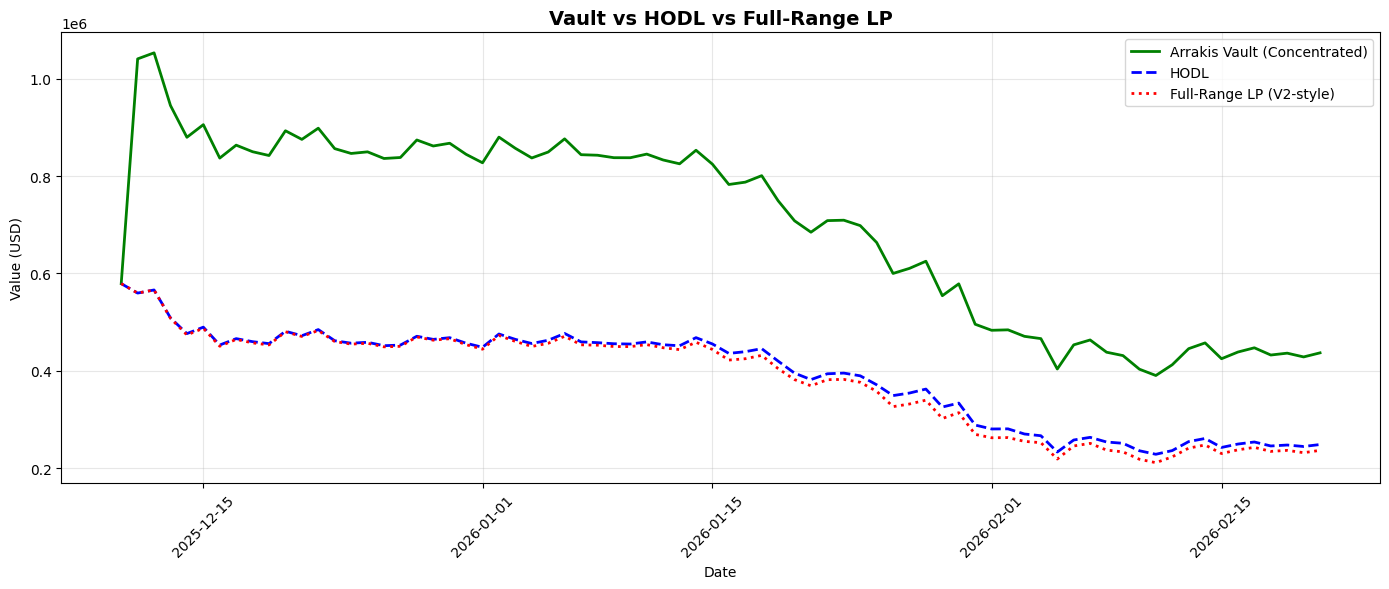

In [9]:
init_ixs_usd = ixs_usd_prices[0]
init_eth_usd = eth_usd_prices[0]

fullrange_values = [
    calculate_fullrange_lp_value(
        init_ixs, init_eth, init_ixs_usd, init_eth_usd, iu, eu
    )
    for iu, eu in zip(ixs_usd_prices, eth_usd_prices)
]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates, total_usd, 'g-', linewidth=2, label='Arrakis Vault (Concentrated)')
ax.plot(dates, hodl_values, 'b--', linewidth=2, label='HODL')
ax.plot(dates, fullrange_values, 'r:', linewidth=2, label='Full-Range LP (V2-style)')

ax.set_xlabel('Date')
ax.set_ylabel('Value (USD)')
ax.set_title('Vault vs HODL vs Full-Range LP', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('plots/ixs_vault_performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Q4. Performance Differential and Tradeoffs

In [10]:
print("=" * 60)
print("VAULT PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Period: {sample_dates[0]} to {sample_dates[-1]}")
print(f"\nInitial: {init_ixs:,.2f} IXS + {init_eth:.4f} ETH = ${total_usd[0]:,.2f}")

print(f"\nFinal values:")
print(f"  Vault:      ${total_usd[-1]:,.2f}")
print(f"  HODL:       ${hodl_values[-1]:,.2f}")
print(f"  Full-Range: ${fullrange_values[-1]:,.2f}")

if total_usd[0] > 0:
    print(f"\nReturns vs initial:")
    print(f"  Vault:      {(total_usd[-1]/total_usd[0] - 1)*100:+.2f}%")
    print(f"  HODL:       {(hodl_values[-1]/total_usd[0] - 1)*100:+.2f}%")
    print(f"  Full-Range: {(fullrange_values[-1]/total_usd[0] - 1)*100:+.2f}%")

if hodl_values[-1] > 0:
    il_fr = (fullrange_values[-1]/hodl_values[-1] - 1) * 100
    il_vault = (total_usd[-1]/hodl_values[-1] - 1) * 100
    print(f"\nImpermanent Loss (vs HODL):")
    print(f"  Full-Range: {il_fr:+.2f}%")
    print(f"  Vault:      {il_vault:+.2f}%")
    print(f"\nThe vault {'outperforms' if il_vault > il_fr else 'underperforms'} full-range LP by {abs(il_vault - il_fr):.2f}pp")

VAULT PERFORMANCE SUMMARY
Period: 2025-12-10 to 2026-02-21

Initial: 1,887,273.11 IXS + 70.2720 ETH = $579,198.47

Final values:
  Vault:      $437,081.28
  HODL:       $248,809.70
  Full-Range: $236,808.03

Returns vs initial:
  Vault:      -24.54%
  HODL:       -57.04%
  Full-Range: -59.11%

Impermanent Loss (vs HODL):
  Full-Range: -4.82%
  Vault:      +75.67%

The vault outperforms full-range LP by 80.49pp


### Return Decomposition

$$V_{\text{vault}} = V_{\text{HODL}} + \underbrace{(V_{\text{fullrange}} - V_{\text{HODL}})}_{\text{IL (full-range)}} + \underbrace{(V_{\text{vault}} - V_{\text{fullrange}})}_{\text{management premium}}$$

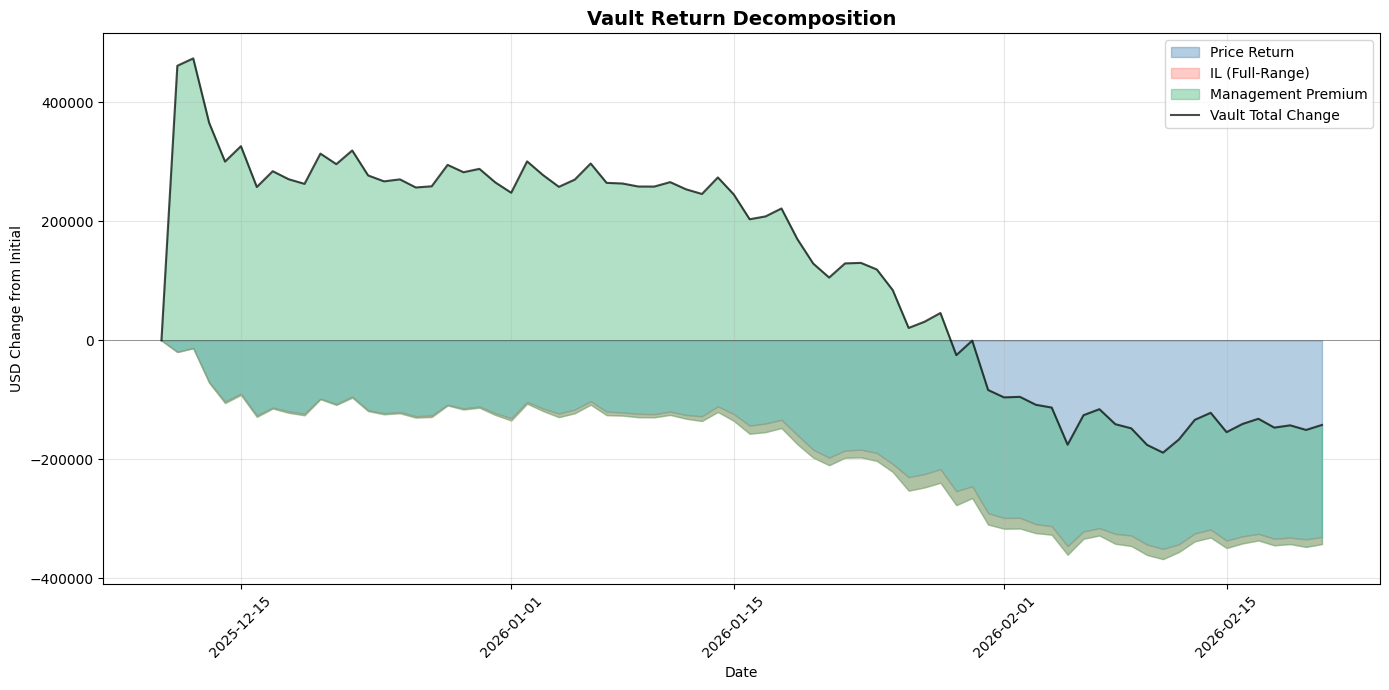

Final Return Decomposition (USD):
  Initial value:       $579,198.47
  + Price return:      $-330,388.78
  + IL (full-range):   $-12,001.67
  + Mgmt premium:      $+200,273.25
  = Vault value:       $437,081.28

  Identity check: 579198.47 + -330388.78 + -12001.67 + 200273.25 = 437081.28 (vault = 437081.28)


In [11]:
# Decompose vault returns
decomp = decompose_vault_returns(total_usd, hodl_values, fullrange_values)

price_returns = [d['price_return'] for d in decomp]
il_components = [d['il_fullrange'] for d in decomp]
mgmt_premiums = [d['management_premium'] for d in decomp]

# Stacked area chart
fig, ax = plt.subplots(figsize=(14, 7))

# Plot as changes from initial value
initial_val = hodl_values[0]
ax.fill_between(dates, 0, price_returns, alpha=0.4, color='steelblue', label='Price Return')
ax.fill_between(dates, price_returns,
                [p + il for p, il in zip(price_returns, il_components)],
                alpha=0.4, color='salmon', label='IL (Full-Range)')
ax.fill_between(dates, [p + il for p, il in zip(price_returns, il_components)],
                [p + il + m for p, il, m in zip(price_returns, il_components, mgmt_premiums)],
                alpha=0.4, color='mediumseagreen', label='Management Premium')

# Vault total change line
vault_changes = [v - initial_val for v in total_usd]
ax.plot(dates, vault_changes, 'k-', linewidth=1.5, alpha=0.7, label='Vault Total Change')

ax.set_xlabel('Date')
ax.set_ylabel('USD Change from Initial')
ax.set_title('Vault Return Decomposition', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('plots/ixs_vault_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final decomposition
d_final = decomp[-1]
print(f"Final Return Decomposition (USD):")
print(f"  Initial value:       ${initial_val:,.2f}")
print(f"  + Price return:      ${d_final['price_return']:+,.2f}")
print(f"  + IL (full-range):   ${d_final['il_fullrange']:+,.2f}")
print(f"  + Mgmt premium:      ${d_final['management_premium']:+,.2f}")
print(f"  = Vault value:       ${total_usd[-1]:,.2f}")

# Verify identity
reconstructed = initial_val + d_final['price_return'] + d_final['il_fullrange'] + d_final['management_premium']
print(f"\n  Identity check: {initial_val:.2f} + {d_final['price_return']:.2f} + {d_final['il_fullrange']:.2f} + {d_final['management_premium']:.2f} = {reconstructed:.2f} (vault = {total_usd[-1]:.2f})")

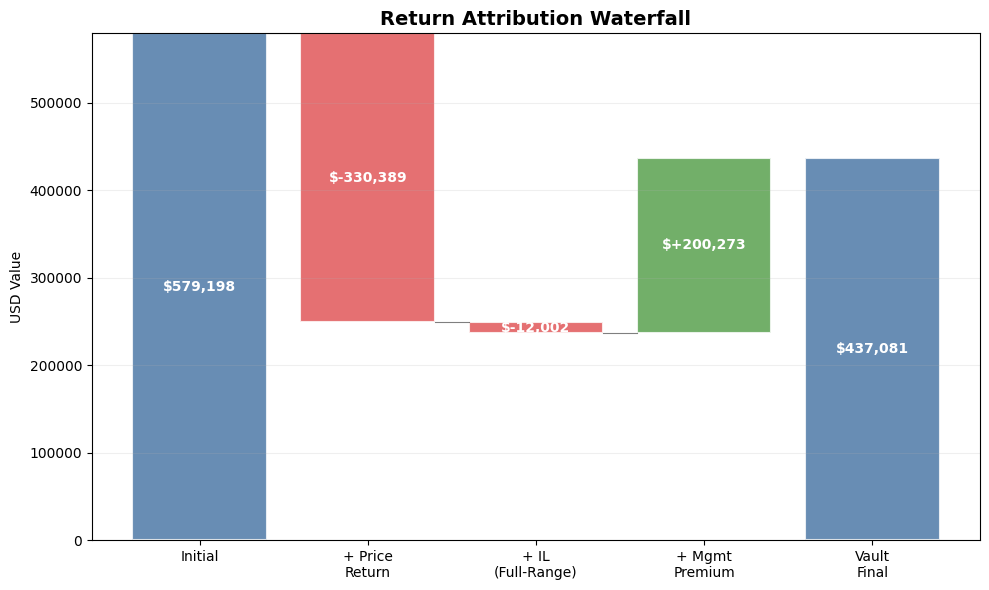

In [12]:
# Waterfall bar chart: initial → +price → +IL → +premium → vault
labels = ['Initial', '+ Price\nReturn', '+ IL\n(Full-Range)', '+ Mgmt\nPremium', 'Vault\nFinal']
values = [
    initial_val,
    d_final['price_return'],
    d_final['il_fullrange'],
    d_final['management_premium'],
    total_usd[-1],
]

# For waterfall: compute cumulative bottoms
bottoms = [0, initial_val, initial_val + d_final['price_return'],
           initial_val + d_final['price_return'] + d_final['il_fullrange'], 0]
bar_heights = values.copy()
colors = ['#4e79a7', '#59a14f' if values[1] >= 0 else '#e15759',
          '#e15759' if values[2] < 0 else '#59a14f',
          '#59a14f' if values[3] >= 0 else '#e15759', '#4e79a7']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, bar_heights, bottom=bottoms, color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)

# Add value labels
for bar, val, bottom in zip(bars, values, bottoms):
    y_pos = bottom + val / 2 if val > 0 else bottom + val / 2
    label = f'${val:+,.0f}' if val != initial_val and val != total_usd[-1] else f'${val:,.0f}'
    ax.text(bar.get_x() + bar.get_width()/2, y_pos, label,
            ha='center', va='center', fontweight='bold', fontsize=10, color='white')

# Connect bars with lines
for i in range(len(labels) - 2):
    top = bottoms[i] + values[i]
    ax.plot([i + 0.4, i + 0.6], [top, top], 'k-', linewidth=0.8, alpha=0.5)

ax.set_ylabel('USD Value')
ax.set_title('Return Attribution Waterfall', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.2, axis='y')
plt.tight_layout()
plt.savefig('plots/ixs_vault_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()

### Annualized Performance

In [13]:
# Compute observation period in days
from datetime import datetime
start_dt = datetime.strptime(sample_dates[0], '%Y-%m-%d')
end_dt = datetime.strptime(sample_dates[-1], '%Y-%m-%d')
days = (end_dt - start_dt).days
print(f"Observation period: {days} days ({days/30.44:.1f} months)")

# Annualized returns
vault_ann = compute_annualized_return(total_usd[0], total_usd[-1], days)
hodl_ann = compute_annualized_return(hodl_values[0], hodl_values[-1], days)
fr_ann = compute_annualized_return(fullrange_values[0], fullrange_values[-1], days)

print(f"\n{'='*50}")
print(f"  ANNUALIZED PERFORMANCE")
print(f"{'='*50}")
print(f"{'Strategy':<20} {'Total Return':>14} {'Annualized':>12}")
print("-" * 46)

vault_ret = (total_usd[-1] / total_usd[0] - 1) * 100
hodl_ret = (hodl_values[-1] / hodl_values[0] - 1) * 100
fr_ret = (fullrange_values[-1] / fullrange_values[0] - 1) * 100

print(f"{'Arrakis Vault':<20} {vault_ret:>+13.2f}% {vault_ann:>+11.2f}%")
print(f"{'HODL':<20} {hodl_ret:>+13.2f}% {hodl_ann:>+11.2f}%")
print(f"{'Full-Range LP':<20} {fr_ret:>+13.2f}% {fr_ann:>+11.2f}%")

# Management premium in pp (annualized)
mgmt_pp = vault_ann - fr_ann
print(f"\nManagement premium (vs full-range): {mgmt_pp:+.2f}pp annualized")

# Component percentages
if total_usd[-1] != initial_val:
    total_change = total_usd[-1] - initial_val
    print(f"\nReturn Attribution (% of total change):")
    print(f"  Price return:      {d_final['price_return']/total_change*100:+.1f}%")
    print(f"  IL (full-range):   {d_final['il_fullrange']/total_change*100:+.1f}%")
    print(f"  Mgmt premium:      {d_final['management_premium']/total_change*100:+.1f}%")

Observation period: 73 days (2.4 months)

  ANNUALIZED PERFORMANCE
Strategy               Total Return   Annualized
----------------------------------------------
Arrakis Vault               -24.54%      -75.53%
HODL                        -57.04%      -98.54%
Full-Range LP               -59.11%      -98.86%

Management premium (vs full-range): +23.33pp annualized

Return Attribution (% of total change):
  Price return:      +232.5%
  IL (full-range):   +8.4%
  Mgmt premium:      -140.9%


---

## Additional Analysis: Active Liquidity Management

How does Arrakis create value? By actively rebalancing the vault's tick ranges to keep liquidity concentrated near the current price. We track ranges via the Arrakis module contract's `getRanges()` function, detect rebalance events, and compute capital efficiency.

In [ ]:
# Range data and rebalances already computed in Q1 data fetch
print(f"Fetched {len(range_data)} samples")
print(f"\nDetected {len(rebalance_idx)} rebalance events")
for idx in rebalance_idx:
    prev = range_data[idx - 1]["ranges"]
    curr = range_data[idx]["ranges"]
    print(f"  Block {range_data[idx]['block']:,} ({sample_dates[idx]}): {prev} -> {curr}")

In [ ]:
# Estimate rebalancing gas cost
from src.vault_rebalancing import estimate_rebalancing_gas_cost

# Fetch baseFeePerGas at each rebalance block
rebalance_blocks = [range_data[idx]["block"] for idx in rebalance_idx]

_params = {"rebalance_blocks": rebalance_blocks}
_cached = load_cache("vault_gas_prices", _params)
if _cached is None:
    gas_prices_gwei = []
    for blk in rebalance_blocks:
        block_data = w3.eth.get_block(blk)
        base_fee = block_data.get("baseFeePerGas", 0)
        gas_prices_gwei.append(base_fee / 1e9)  # wei -> gwei
    save_cache("vault_gas_prices", gas_prices_gwei, _params)
else:
    gas_prices_gwei = _cached

avg_gas_price = sum(gas_prices_gwei) / len(gas_prices_gwei) if gas_prices_gwei else 0
avg_eth_usd = sum(eth_usd_prices) / len(eth_usd_prices)

# Arrakis rebalance() typically costs 200K-400K gas
AVG_GAS_PER_REBALANCE = 300_000
gas_cost_usd = estimate_rebalancing_gas_cost(
    len(rebalance_idx), AVG_GAS_PER_REBALANCE, avg_gas_price, avg_eth_usd
)

print(f"Rebalancing Gas Cost Estimate")
print(f"  Rebalances:          {len(rebalance_idx)}")
print(f"  Avg gas price:       {avg_gas_price:.1f} gwei")
print(f"  Avg ETH/USD:         ${avg_eth_usd:,.0f}")
print(f"  Est. gas per rebal:  {AVG_GAS_PER_REBALANCE:,}")
print(f"  Total gas cost:      ${gas_cost_usd:,.2f}")
if d_final['management_premium'] != 0:
    print(f"  As % of mgmt prem:   {gas_cost_usd / abs(d_final['management_premium']) * 100:.1f}%")

In [ ]:
# Plot: Price + Range Bands + Rebalance Markers
# V4 pool: currency0=ETH, currency1=IXS → sqrtPriceX96 encodes IXS/ETH
# We want ETH per IXS for the y-axis (same units as ixs_eth_prices)

fig, ax = plt.subplots(figsize=(14, 7))

# Pool price over time (ETH per IXS = 1/price since price = IXS/ETH)
pool_prices_eth_per_ixs = []
for rd in range_data:
    if rd["price"] > 0:
        pool_prices_eth_per_ixs.append(1.0 / rd["price"])
    else:
        pool_prices_eth_per_ixs.append(0.0)

ax.plot(dates, pool_prices_eth_per_ixs, color='#2ca02c', linewidth=1.8, label='IXS/ETH Price', zorder=3)

# Shade vault range bands (convert ticks to ETH-per-IXS prices)
for i in range(len(range_data)):
    rd = range_data[i]
    if not rd["ranges"]:
        continue
    # Date span for this sample
    d_start = dates[i]
    d_end = dates[i + 1] if i + 1 < len(dates) else dates[i]

    for tick_lower, tick_upper in rd["ranges"]:
        # tick_to_sqrt_price^2 gives IXS/ETH → invert for ETH/IXS
        price_lower_ixs_eth = tick_to_sqrt_price(tick_lower) ** 2
        price_upper_ixs_eth = tick_to_sqrt_price(tick_upper) ** 2
        # Invert: ETH per IXS
        band_low = 1.0 / price_upper_ixs_eth if price_upper_ixs_eth > 0 else 0
        band_high = 1.0 / price_lower_ixs_eth if price_lower_ixs_eth > 0 else 0
        ax.axhspan(band_low, band_high, xmin=i/len(dates), xmax=(i+1)/len(dates),
                   alpha=0.15, color='#2ca02c', zorder=1)

# Rebalance markers
for idx in rebalance_idx:
    ax.axvline(dates[idx], color='red', linestyle='--', alpha=0.6, linewidth=1, zorder=2)
if rebalance_idx:
    ax.axvline(dates[rebalance_idx[0]], color='red', linestyle='--', alpha=0.6,
               linewidth=1, label='Rebalance Event')

ax.set_xlabel('Date')
ax.set_ylabel('ETH per IXS')
ax.set_title('Price Tracking: Vault Range Bands Follow the Price', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('plots/ixs_vault_price_ranges.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Plot: Active Liquidity Over Time
liq_values = [rd["liquidity"] for rd in range_data]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates, liq_values, color='#4e79a7', linewidth=1.8, label='Active In-Range Liquidity')

for idx in rebalance_idx:
    ax.axvline(dates[idx], color='red', linestyle='--', alpha=0.5, linewidth=1)
if rebalance_idx:
    ax.axvline(dates[rebalance_idx[0]], color='red', linestyle='--', alpha=0.5,
               linewidth=1, label='Rebalance Event')

ax.set_xlabel('Date')
ax.set_ylabel('Liquidity (L)')
ax.set_title('Active In-Range Liquidity Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('plots/ixs_vault_active_liquidity.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Liquidity range: {min(liq_values):,.0f} - {max(liq_values):,.0f}")
print(f"Current liquidity: {liq_values[-1]:,.0f}")

In [ ]:
# Plot: Capital Efficiency Over Time
# CE = actual L / theoretical full-range L for same TVL
# Must use raw (wei) amounts since Uniswap L = sqrt(x_raw * y_raw)
if ixs_is_token0_vault:
    raw_ixs = [d[1] for d in vault_data]
    raw_eth = [d[2] for d in vault_data]
else:
    raw_ixs = [d[2] for d in vault_data]
    raw_eth = [d[1] for d in vault_data]

ce_ratios = []
for i, rd in enumerate(range_data):
    ce = compute_capital_efficiency(rd["liquidity"], raw_ixs[i], raw_eth[i])
    ce_ratios.append(ce)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(dates, ce_ratios, color='#59a14f', linewidth=1.8, label='Capital Efficiency Ratio')
ax.axhline(y=1.0, color='gray', linestyle=':', linewidth=1.5, label='Full-Range Baseline (1.0x)')

for idx in rebalance_idx:
    ax.axvline(dates[idx], color='red', linestyle='--', alpha=0.5, linewidth=1)
if rebalance_idx:
    ax.axvline(dates[rebalance_idx[0]], color='red', linestyle='--', alpha=0.5,
               linewidth=1, label='Rebalance Event')

ax.set_xlabel('Date')
ax.set_ylabel('CE Ratio (Concentrated / Full-Range)')
ax.set_title('Capital Efficiency: Concentration Multiplier Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('plots/ixs_vault_capital_efficiency.png', dpi=150, bbox_inches='tight')
plt.show()

nz_ce = [c for c in ce_ratios if c > 0]
if nz_ce:
    print(f"Capital efficiency: {min(nz_ce):.1f}x - {max(nz_ce):.1f}x (median: {sorted(nz_ce)[len(nz_ce)//2]:.1f}x)")
    print(f"Current: {ce_ratios[-1]:.1f}x more efficient than full-range")

In [ ]:
# Arrakis-Style Snapshot: 2x2 grid showing range evolution over time
# X = price (ETH per IXS), Y = liquidity depth (narrower = taller)
from src.amm_math import tick_to_sqrt_price
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def draw_arrakis_snapshot(ax, snap, label, date_label):
    """Draw one Arrakis-style liquidity concentration snapshot."""
    current_eth_per_ixs = 1.0 / snap["price"] if snap["price"] > 0 else 0

    # Convert tick ranges to ETH-per-IXS prices
    range_bars = []
    for tl, tu in snap["ranges"]:
        p_lo_ixs = tick_to_sqrt_price(tl) ** 2
        p_hi_ixs = tick_to_sqrt_price(tu) ** 2
        eth_lo = 1.0 / p_hi_ixs
        eth_hi = 1.0 / p_lo_ixs
        range_bars.append((eth_lo, eth_hi, tu - tl))

    all_eth = [current_eth_per_ixs] + [v for lo, hi, _ in range_bars for v in (lo, hi)]
    x_min, x_max = min(all_eth) * 0.5, max(all_eth) * 1.15

    # Full-range bar: wide, flat, blue
    fr_h = 0.6
    ax.bar((x_min + x_max) / 2, fr_h, width=(x_max - x_min) * 0.98,
           bottom=0, color='#a8d5e2', alpha=0.5, edgecolor='#5b9bd5', linewidth=1, zorder=1)
    ax.text((x_min + x_max) / 2, fr_h / 2, 'Full Range',
            fontsize=7, ha='center', va='center', color='#3a7ca5', fontweight='bold', alpha=0.7)
    ax.annotate('', xy=(x_min * 1.01, fr_h / 2), xytext=(x_min * 1.08, fr_h / 2),
                arrowprops=dict(arrowstyle='<-', color='#5b9bd5', lw=1.2))
    ax.annotate('', xy=(x_max * 0.99, fr_h / 2), xytext=(x_max * 0.93, fr_h / 2),
                arrowprops=dict(arrowstyle='<-', color='#5b9bd5', lw=1.2))

    # Vault ranges: staircase (widest first, narrowest tallest)
    range_bars.sort(key=lambda r: -(r[1] - r[0]))
    n = len(range_bars)
    for i, (eth_lo, eth_hi, tw) in enumerate(range_bars):
        height = 1.5 + 2.5 * (i + 1) / n
        ax.bar((eth_lo + eth_hi) / 2, height, width=eth_hi - eth_lo,
               bottom=fr_h, color='#f5c896', alpha=0.8, edgecolor='#d4915e',
               linewidth=1.5, zorder=2 + i)

    # Current price
    ax.axvline(current_eth_per_ixs, color='#333333', linestyle=':', linewidth=2.5, zorder=10)

    # Token labels
    ax.text(x_min + (current_eth_per_ixs - x_min) * 0.3, 5.8, 'ETH',
            fontsize=14, fontweight='bold', color='#5b9bd5', ha='center', style='italic')
    ax.text(current_eth_per_ixs + (x_max - current_eth_per_ixs) * 0.7, 5.8, 'IXS',
            fontsize=14, fontweight='bold', color='#d4915e', ha='center', style='italic')

    # Bootstrapping label
    narrowest = min(range_bars, key=lambda r: r[1] - r[0])
    ax.text((narrowest[0] + narrowest[1]) / 2, fr_h + 1.5 + 2.5 + 0.3,
            'Bootstrapping\nRanges', fontsize=7, ha='center', va='bottom',
            style='italic', color='#8b6914')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.15, 6.8)
    ax.set_xlabel('Price', fontsize=10)
    ax.set_title(f'{label} ({date_label})', fontsize=11, fontweight='bold')
    ax.set_yticks([])
    ax.set_xticklabels([])
    for sp in ['top', 'right', 'left']:
        ax.spines[sp].set_visible(False)
    ax.annotate('', xy=(x_max, 0), xytext=(x_min, 0),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.2))

# Pick 4 representative time points
# First with ranges, ~1/3, ~2/3, and latest
first_with_ranges = next(i for i, rd in enumerate(range_data) if rd["ranges"])
n_samples = len(range_data)
snap_indices = [
    first_with_ranges,
    first_with_ranges + (n_samples - first_with_ranges) // 3,
    first_with_ranges + 2 * (n_samples - first_with_ranges) // 3,
    -1,
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
labels = ['Launch', 'Mid-January', 'Early February', 'Current']
for ax, idx, label in zip(axes.flat, snap_indices, labels):
    draw_arrakis_snapshot(ax, range_data[idx], label, sample_dates[idx])

legend_elements = [
    Patch(facecolor='#a8d5e2', alpha=0.5, edgecolor='#5b9bd5', label='Full Range'),
    Patch(facecolor='#f5c896', alpha=0.8, edgecolor='#d4915e', label='Vault Ranges'),
    Line2D([0], [0], color='#333333', linestyle=':', linewidth=2.5, label='Current Price'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11,
           framealpha=0.9, bbox_to_anchor=(0.5, -0.01))
fig.suptitle('Liquidity Concentration Over Time: Arrakis Vault Range Evolution',
             fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('plots/ixs_vault_snapshot_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Data Export

In [ ]:
# Enhanced summary with annualized figures and decomposition
print("=" * 60)
print("VAULT PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Period: {sample_dates[0]} to {sample_dates[-1]} ({days} days)")
print(f"\nInitial: {init_ixs:,.2f} IXS + {init_eth:.4f} ETH = ${total_usd[0]:,.2f}")

print(f"\n{'Strategy':<20} {'Final USD':>14} {'Return':>10} {'Annualized':>12}")
print("-" * 56)
print(f"{'Arrakis Vault':<20} ${total_usd[-1]:>12,.2f} {vault_ret:>+9.2f}% {vault_ann:>+11.2f}%")
print(f"{'HODL':<20} ${hodl_values[-1]:>12,.2f} {hodl_ret:>+9.2f}% {hodl_ann:>+11.2f}%")
print(f"{'Full-Range LP':<20} ${fullrange_values[-1]:>12,.2f} {fr_ret:>+9.2f}% {fr_ann:>+11.2f}%")

print(f"\nManagement premium: {mgmt_pp:+.2f}pp annualized")
print(f"Rebalancing gas cost: ${gas_cost_usd:,.2f} ({len(rebalance_idx)} rebalances)")

print(f"\nReturn Decomposition (final):")
print(f"  Price return:      ${d_final['price_return']:+,.2f}")
print(f"  IL (full-range):   ${d_final['il_fullrange']:+,.2f}")
print(f"  Mgmt premium:      ${d_final['management_premium']:+,.2f}")

# Export vault summary CSV for D3
os.makedirs('data', exist_ok=True)
vault_export = pd.DataFrame({
    'metric': ['period_start', 'period_end', 'days',
               'vault_initial_usd', 'vault_final_usd', 'hodl_final_usd', 'fullrange_final_usd',
               'vault_return_pct', 'hodl_return_pct', 'fullrange_return_pct',
               'vault_ann_pct', 'hodl_ann_pct', 'fullrange_ann_pct',
               'price_return_usd', 'il_fullrange_usd', 'mgmt_premium_usd',
               'mgmt_premium_ann_pp',
               'n_rebalances', 'gas_cost_usd'],
    'value': [sample_dates[0], sample_dates[-1], days,
              round(total_usd[0], 2), round(total_usd[-1], 2),
              round(hodl_values[-1], 2), round(fullrange_values[-1], 2),
              round(vault_ret, 4), round(hodl_ret, 4), round(fr_ret, 4),
              round(vault_ann, 4), round(hodl_ann, 4), round(fr_ann, 4),
              round(d_final['price_return'], 2), round(d_final['il_fullrange'], 2),
              round(d_final['management_premium'], 2), round(mgmt_pp, 4),
              len(rebalance_idx), round(gas_cost_usd, 2)],
})
vault_export.to_csv('data/vault_summary.csv', index=False)
print(f"\nExported vault summary to data/vault_summary.csv")